In [46]:
import random
import os

from surprise import accuracy, Dataset
from surprise import KNNBasic, KNNWithZScore, KNNBaseline, BaselineOnly, SVD
from surprise.model_selection import cross_validate, GridSearchCV

import pandas as pd
import matplotlib.pyplot as plot
from joblib import dump, load

# Data Preprocessing

In [2]:
# Pull MovieLens dataset
dataset = Dataset.load_builtin("ml-100k")
raw_ratings = dataset.raw_ratings
# shuffle rating
random.shuffle(raw_ratings)

# https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-save-some-data-for-unbiased-accuracy-estimation
# train and test dataset split A = 90% of the data, B = 10% of the data.
# test data is used to compare the performance across different models
threshold = int(0.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

dataset.raw_ratings = A_raw_ratings  # data is now the set A

In [3]:
ratings = dataset.raw_ratings

print("Number of rating instances ", len(ratings))
print("Number of unique users: ", len(set([x[0] for x in ratings])))
print("Number of unique items: ", len(set([x[1] for x in ratings])))

Number of rating instances  90000
Number of unique users:  943
Number of unique items:  1675


In [5]:
train_df = pd.DataFrame(A_raw_ratings)
dev_df = pd.DataFrame(B_raw_ratings)

# Helper Function

In [6]:
def gridsearch_cv_helper(param_grid, model):
    # cross validation with 5 validation sets
    gs = GridSearchCV(model, param_grid, measures=["rmse"], cv=5)
    gs.fit(dataset)

    print(gs.best_score["rmse"])

    # combination of parameters that gave the best RMSE score
    print(gs.best_params["rmse"])

    results_df = pd.DataFrame.from_dict(gs.cv_results)

    # We can now use the algorithm that yields the best rmse:
    algo = gs.best_estimator["rmse"]

    return (results_df, algo)

In [7]:
def train_algo(algo):
    # retrain on the whole set A
    dataset.raw_ratings = A_raw_ratings
    trainset = dataset.build_full_trainset()
    algo.fit(trainset)

    # Compute biased accuracy on A
    #predictions = algo.test(trainset.build_testset())
    #print("Biased accuracy on A,", end="   ")
    #accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = dataset.construct_testset(B_raw_ratings)  # testset is now the set B
    predictions = algo.test(testset)
    result = accuracy.rmse(predictions)
    print(f"Unbiased accuracy on B, RMSE {result}")
    
    return result

In [43]:
def save_results(results_df, algo, name):
    directory_path = "model/"
    full_path = os.path.join(directory_path, "{}.csv".format(name))
    results_df.to_csv(full_path)
    # save model
    full_path = os.path.join(directory_path, "{}.joblib".format(name))
    dump(algo, full_path)

In [44]:
def load_results(name):
    directory_path = "model/"
    full_path = os.path.join(directory_path, "{}.csv".format(name))
    df = pd.read_csv(full_path)
    # load algo
    full_path = os.path.join(directory_path, "{}.joblib".format(name))
    algo = load(full_path)
    return df, algo

# Baseline

In [ ]:
# Ratings based on the average of the whole rating sets
# mean ratings + difference of average of the movie and mean + difference of average of the user and mean

In [10]:
clf = BaselineOnly()
cross_validate(clf, dataset, measures=['rmse'], cv=5, verbose=True)
baseline_rmse = train_algo(clf)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9468  0.9428  0.9501  0.9455  0.9465  0.9463  0.0024  
Fit time          0.25    0.27    0.28    0.27    0.27    0.27    0.01    
Test time         0.12    0.19    0.11    0.18    0.12    0.14    0.03    
Estimating biases using als...
RMSE: 0.9339
Unbiased accuracy on B, RMSE 0.933863318748464


# Collaborative Filtering - Memory Based

## KNN Basic
KNN model finds the number of similar users and predict ratings by taking the average of ratings given by the neighbors

In [ ]:
# user based KNN
param_grid = {'k': [4, 6, 8, 10, 12], # number of neighbors
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],  #MSD(Mean Squared Difference), cosine, pearson(pearson correlation coefficient)
                              'min_support': [1, 2, 3],
                              'user_based': [True]}
             }
# find the best parameters and save the model
results_df, algo = gridsearch_cv_helper(param_grid, KNNBasic)
save_results(results_df, algo, "knn_basic_user_model")

In [45]:
knn_user_results_df, knn_user_algo = load_results("knn_basic_user_model")
# RMSE of the test dataset with the best parameter
knn_user_test_result = train_algo(knn_user_algo)

NameError: name 'os' is not defined

In [12]:
#item based KNN
param_grid = {'k': [4, 6, 8, 10, 12],
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],  #MSD(Mean Squared Difference), cosine, pearson(pearson correlation coefficient)
                              'min_support': [1, 2, 3],
                              'user_based': [False]}
             }
    

results_df, algo = gridsearch_cv_helper(param_grid, KNNBasic)
save_results(results_df, algo, "knn_basic_item_model")

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

In [13]:
knn_item_results_df, knn_item_algo = load_results("knn_basic_item_model")
knn_item_test_result = train_algo(knn_item_algo)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9668
Unbiased accuracy on B, RMSE 0.9668409850252786


## KNNWithZscore - Rating Centering and Nomalization

In [ ]:
#User based KNN with Zscore
param_grid = {
    'k': [4, 6, 8, 10, 12],
    'sim_options': {'name': ['msd', 'cosine', 'pearson'],  #MSD(Mean Squared Difference), cosine, pearson(pearson correlation coefficient)
                              'min_support': [1, 2, 3], # minimum number of common users for the similarity not to be zero
                              'user_based': [True]}
}
    

results_df, algo = gridsearch_cv_helper(param_grid, KNNWithZScore)
save_results(results_df, algo, "knn_zscore_user_model")

In [14]:
knn_z_df, knn_zscore_user_algo = load_results("knn_zscore_user_model")
knn_z_rmse = train_algo(knn_zscore_user_algo)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9455
Unbiased accuracy on B, RMSE 0.9455011213700075


In [15]:
# flatten the param option to plot the results
knn_z_df['param_sim_options'] = knn_z_df['param_sim_options'].apply(lambda x : dict(eval(x)) )
knn_z_df = pd.concat([knn_z_df.drop(['param_sim_options'], axis=1), knn_z_df['param_sim_options'].apply(pd.Series)], axis=1)

name
cosine     AxesSubplot(0.125,0.125;0.775x0.755)
msd        AxesSubplot(0.125,0.125;0.775x0.755)
pearson    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mean_test_rmse, dtype: object

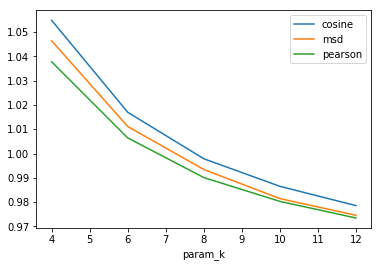

In [16]:
# RMSE plot for different similarity measurements
knn_z_df_2 = knn_z_df.loc[knn_z_df['min_support'] == 3]
knn_z_df_2.set_index('param_k', inplace=True)
knn_z_df_2.groupby('name')['mean_test_rmse'].plot(legend=True)

# Model Based Collaborative Filtering 

## SVD

In [ ]:
# Truncated singular value decomposition with 20, 40, 60, 80 latent factors
# stochastic gradient descent is used to minimize the loss and to estimate the strength of latent factors
param_grid = {
    'n_factors': [20, 40, 60, 80],
    'n_epochs': [20, 40, 60],
    'lr_all': [0.005, 0.01], # learning rate
    'reg_all': [0.02, 0.1]} # regularization term
results_df, algo = gridsearch_cv_helper(param_grid, SVD)
save_results(results_df, algo, "svd")

In [19]:
svd_results_df, svd_algo = load_results("svd")

In [32]:
svd_algo

In [20]:
svd_result = train_algo(svd_algo)

RMSE: 0.8957
Unbiased accuracy on B, RMSE 0.8957131512342251


In [ ]:
# svd result plot by n_factors for lr_all 0.010 and reg_all 0.10

In [40]:
svd_results_df_2 = svd_results_df[(svd_results_df['param_lr_all'] == 0.010) & (svd_results_df['param_reg_all'] == 0.10)]

param_n_factors
20    AxesSubplot(0.125,0.125;0.775x0.755)
40    AxesSubplot(0.125,0.125;0.775x0.755)
60    AxesSubplot(0.125,0.125;0.775x0.755)
80    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mean_test_rmse, dtype: object

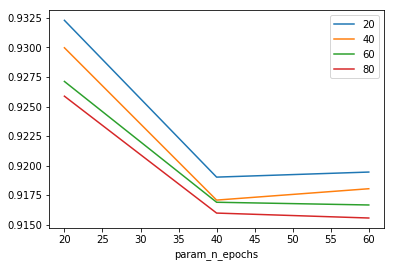

In [42]:
# RMSE plot for different similarity measurements
svd_results_df_2.set_index('param_n_epochs', inplace=True)
svd_results_df_2.groupby('param_n_factors')['mean_test_rmse'].plot(legend=True)

When the model was trained with more latent factors, performance improved. After 40 epochs, there wasn't no significant performance gains beyond that point.

# RMSE Results and Discussion

In [24]:
df = pd.DataFrame({
    'Models':['Baseline', 'KNN Basic User', 'KNN Basic Item', 'KNN Zscore','SVD'],
    'RMSE':[baseline_rmse, knn_user_test_result, knn_item_test_result, knn_z_rmse, svd_result]})
print(df)

           Models      RMSE
0        Baseline  0.933863
1  KNN Basic User  0.963541
2  KNN Basic Item  0.966841
3      KNN Zscore  0.945501
4             SVD  0.895713


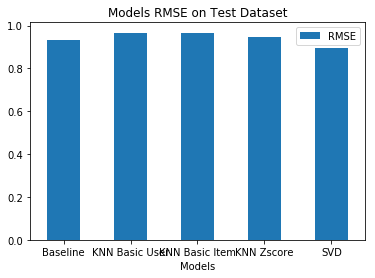

In [25]:
ax = df.plot.bar(x='Models', y='RMSE', rot=0, title="Models RMSE on Test Dataset")
plot.show(block=True);

The above plot illustrates the RMSE on the dev dataset for various tested models, indicating that SVD outperformed the baseline and KNN Zscore.

In real-world scenarios, the user and item matrix can often be highly sparse, meaning that only a few users actively provide ratings. This poses a challenge for the SVD model, as the missing items makes it difficult to accurately estimate the strength of latent factors.

Additionally, the cold start problem, involving predicting ratings for new users, can be a hurdle. While in this dataset, all users in the dev data are seen in the train data, this might not be the case in reality.

To address these challenges, it would be more practical to build a hybrid model. This hybrid model could utilize SVD for users with a lot of historical ratings while predicting ratings for others based on either historical averages on movies or their content/meta information.

In [30]:
# cold start problem
# user existing in dev but not in train -> coldstart problem
len(dev_df), len(dev_df.loc[~dev_df[0].isin(train_df[0])])

(10000, 0)